In [29]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1. Data Preprocessing and Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder('data/train', transform=transform)
test_data = datasets.ImageFolder('data/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4,pin_memory=True,prefetch_factor=2)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4,pin_memory=True,prefetch_factor=2)

# 2. Model Definition (Using Pretrained ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: benign and malignant



/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma-env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma-env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
import torch
print(torch.backends.mps.is_available())   # Should print True

True


In [31]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print(device)  # Should print mps if available, else cpu

mps


In [32]:
print(f"Using device: {device}")
x = torch.rand(1, device=device)
print(x.device)

Using device: mps
mps:0


In [33]:
# 3. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 4. Training Loop (20 Epochs)
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma-env/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/15, Loss: 0.2797
Epoch 2/15, Loss: 0.2126
Epoch 3/15, Loss: 0.1805
Epoch 4/15, Loss: 0.1555
Epoch 5/15, Loss: 0.1323
Epoch 6/15, Loss: 0.1169
Epoch 7/15, Loss: 0.0983
Epoch 8/15, Loss: 0.0858
Epoch 9/15, Loss: 0.0742
Epoch 10/15, Loss: 0.0636
Epoch 11/15, Loss: 0.0589
Epoch 12/15, Loss: 0.0565
Epoch 13/15, Loss: 0.0423
Epoch 14/15, Loss: 0.0396
Epoch 15/15, Loss: 0.0307


In [34]:
model.eval()
all_preds = []
all_labels = []
all_probs = []

threshold = 0.5  # <-- tune this

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of malignant
        preds = (probs > threshold).long()           # classify manually

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())



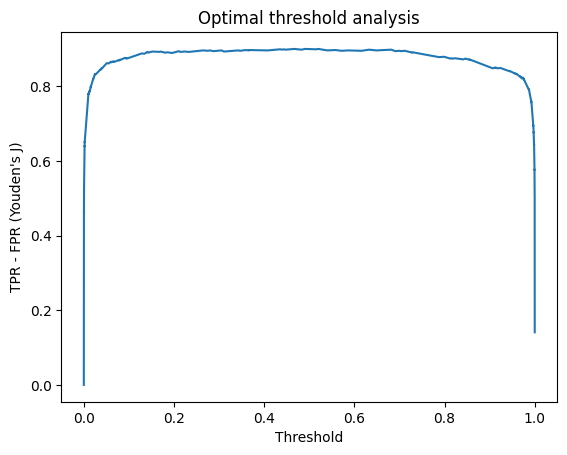

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)  # all_probs = list of model probs for class 1
plt.plot(thresholds, tpr - fpr)
plt.xlabel("Threshold")
plt.ylabel("TPR - FPR (Youden's J)")
plt.title("Optimal threshold analysis")
plt.show()

Confusion Matrix:
[[952  48]
 [ 53 947]]
AUC: 0.9495


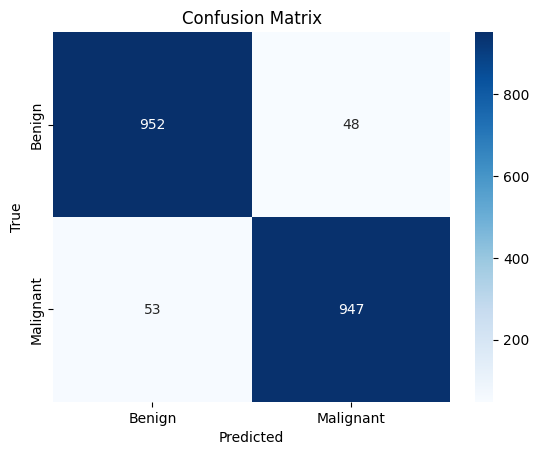

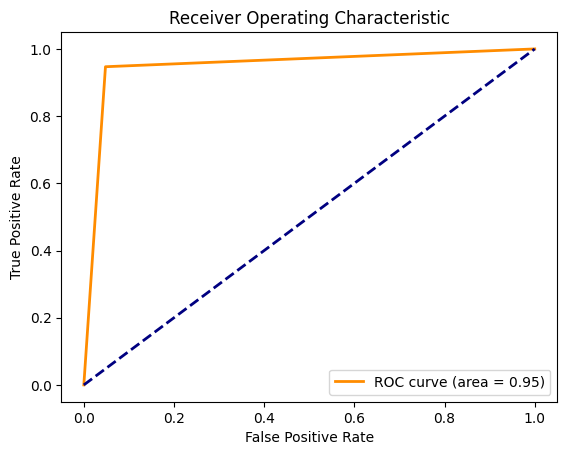

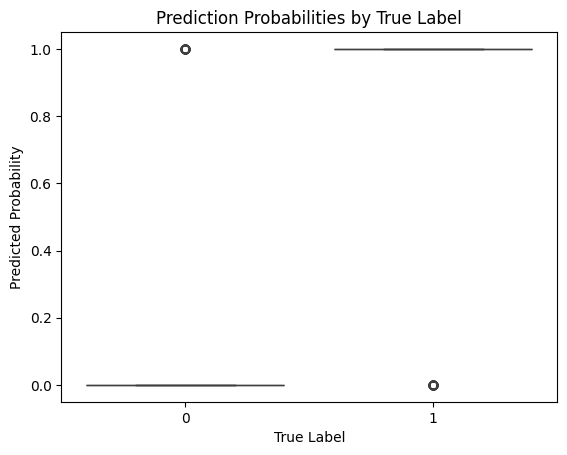

In [36]:
# 6. Metrics Calculation
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 7. AUC ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# 8. Plotting
# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Boxplot of Predictions
sns.boxplot(x=all_labels, y=all_preds)
plt.xlabel('True Label')
plt.ylabel('Predicted Probability')
plt.title('Prediction Probabilities by True Label')
plt.show()

In [37]:
MODEL_PATH = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma_model2
' \
'
.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved at {MODEL_PATH}")

✅ Model saved at /Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma_model2.pth
